In [ ]:
import bibtexparser
import pandas as pd
import os

In [ ]:
download_path = './Data'

In [ ]:
df = pd.DataFrame()

file_name = 'wos_neuro.bib'

file_path = os.path.join(download_path, file_name)
print(file_path)
with open(file_path) as bibtex_file:
    bib_database = bibtexparser.load(bibtex_file)

df_new = pd.DataFrame(bib_database.entries)

if len(df) == 0:
    df = df_new
else:
    df = pd.concat([df, df_new], axis=0, ignore_index=True) 

In [ ]:
df.to_excel('Data/wos_neuro.xlsx')

# LLM을 이용한 논문의 관련성 판단

In [ ]:
from openai import OpenAI
from dotenv import load_dotenv
import os
import time
import json

load_dotenv()
client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))

In [ ]:
tools = [
    {
        "type": "function",
        "function": {
            "name": "analyse_conversation",
            "description": "다음 논문의 제목과 초록을 읽고, 과학학습에서의 신경과학적 측면을 다루는지 판단하기",
            "parameters": {
                "type": "object",
                "properties": {
                    "relevance": {
                        "type": "integer",
                        "enum": [0, 1],
                        "description": "관련성 없음(0), 관련성 있음(1)",
                    },
                    "feedback": {
                        "type": "string",
                        "description": "관련성 판단 근거",
                    },
                    "content": {
                        "type": "string",
                        "description": "신경과학과 관련된 관점",
                    },
                },
                "required": ["relevance", "feedback", "content"],
            },
        }
    },
]

In [ ]:
df['relevance'] = 0
df['content'] = None
df['feedback'] = None

In [ ]:
for i in range(len(df)):
    title = df.loc[i, 'title']
    abstract = df.loc[i, 'abstract']

    if pd.isna(title) and pd.isna(abstract):
        print(f"모두 비어 있음: {i}")
        continue

    query = "다음은 신경과학과 과학학습을 키워드로 조사한 논문의 제목과 초록이야.\n"
    query += f"제목: {title}\n"
    query += f"초록: {abstract}\n\n"
    query += "다음 제목과 초록을 토대로 신경과학의 관점에서 과학 학습(science learning)을 다루는지 판단해 줘.\n"
    query += "관련이 있으면 1, 없으면 0으로 반환하고, 그렇게 판단한 이유를 제시해 줘.\n"
    query += "그리고 신경과학과 관련해서 어떤 내용이 들어가 있는지 추출해 줘. 이 때, 없으면 '없음'으로 반환해."

    messages = []
    messages.append({"role": "system", 
                     "content": "너는 신경과학 및 논문 분석의 전문가야. 없는 내용을 추가하거나 지어내지 말고, 중요한 결과 분석이니까 주어진 기준에 따라 엄밀하고 공정하게 분류해."})
    messages.append({"role": "user", "content": query})

    success = False  # 성공 여부 플래그
    retries = 3      # 재시도 횟수 제한
    attempt = 0      # 현재 시도 횟수

    while not success and attempt < retries:
        try:
            resp = client.chat.completions.create(
                model="gpt-4o",
                messages=messages,
                tools=tools,
            )
            # JSON 파싱 시도
            result = resp.choices[0].message.tool_calls[0].function.arguments
            obj = json.loads(result)
            print(obj)

            df.loc[i, 'relevance'] = obj['relevance']
            df.loc[i, 'content'] = obj['content']
            df.loc[i, 'feedback'] = obj['feedback']
            
            success = True  # 성공 시 플래그 업데이트
        except json.JSONDecodeError as e:
            print(f"JSON Decode Error: {e}. Retrying...")
            attempt += 1  # 시도 횟수 증가
        except Exception as e:
            print(f"Unexpected Error: {e}. Retrying...")
            attempt += 1  # 시도 횟수 증가
    
    if not success:
        print("::::: Failed to process the request after multiple attempts.:", i)

    print(f"* Finished: index {i}")

print("FINALLY DONE!")    

In [ ]:
df.to_excel('Data/wos_neuro.xlsx')

In [ ]:
filtered_df = df[df['relevance'] != 0]
filtered_df.reset_index(drop=True, inplace=True)
filtered_df.to_excel('Data/wos_neuro_r.xlsx')

In [ ]:
print(f"A total number of articles: {len(filtered_df)}")

### 1차 처음 가져온 논문의 숫자는 299개였고, 걸러서 186개가 됨.

# 수집된 논문을 중심으로 한 분석 시작

## 논문에 대한 분류

In [ ]:
import pandas as pd

df = pd.read_excel('Data/wos_neuro_r.xlsx', index_col=0)
df.head()

In [ ]:
for i, item in enumerate(df.doi):
    print(f"----- {i} -----")
    if pd.isna(item):
        print(df.loc[i, 'title'].replace('\n', ' ').strip())
    else:
        print(f"https://libproxy.snu.ac.kr/link.n2s?url=https://doi.org/{item}")

In [ ]:
missing = [19, 24, 27, 30, 40, 51, 52, 61, 72, 76, 78, 82, 84, 98, 101, 118, 120, 127, 135, 153, 161, 172, 182, 185]

In [ ]:
new_df = df.drop(index=missing)

# (선택) 인덱스를 0부터 다시 매기고 싶으면
new_df = new_df.reset_index(drop=True)
new_df.to_excel('Data/wos_neuro_r.xlsx')

In [ ]:
!pip install rapidfuzz

# Parse PDFs

In [ ]:
import pandas as pd

df = pd.read_excel('Data/wos_neuro_r.xlsx', index_col=0)

In [ ]:
df.shape

In [ ]:
from dotenv import load_dotenv

load_dotenv()

In [ ]:
import os

folder_path = './neuro_edu/'
files = [f for f in os.listdir(folder_path)
         if os.path.isfile(os.path.join(folder_path, f))]

# 1) os.path.splitext 사용
#   먼저 .pdf 파일만 걸러내고, splitext()[0]으로 확장자 제거
pdf_names = [os.path.splitext(f)[0] 
             for f in files 
             if f.lower().endswith('.pdf')]

In [ ]:
import pandas as pd
from rapidfuzz import process, fuzz

filtered_pdf_names = []

for name in pdf_names:
    name_lower = name.lower()
    match, score, idx = process.extractOne(
        name_lower,
        df['title'].str.lower(),
        scorer=fuzz.token_sort_ratio,
        score_cutoff=0
    )

    if score >= 80:
        # 유사도가 80 이상이면 리스트에 남겨두기
        filtered_pdf_names.append(name)
    else:
        # 유사도가 80 미만이면 DataFrame에서 해당 행 제거
        df.drop(index=idx, inplace=True)

# pdf_names 업데이트
pdf_names = filtered_pdf_names

# (선택) df의 인덱스를 0부터 다시 매기고 싶으면
df.reset_index(drop=True, inplace=True)

print("남은 df.shape:", df.shape)

In [ ]:
# 인덱스 찾는 함수
def find_index(title):
    title = title.lower()
    match, score, idx = process.extractOne(
        title,
        df['title'].str.lower(),
        scorer=fuzz.token_sort_ratio,
        score_cutoff=0
    )

    return idx

In [ ]:
df['text'] = None

In [ ]:
import requests
import re

api_key = os.getenv("UPSTAGE_API_KEY")

for i, item in enumerate(pdf_names):
    idx = find_index(item)
    print(f"Returned at {idx}")

    file_path = folder_path + item + '.pdf'
    url = "https://api.upstage.ai/v1/document-ai/document-parse"
    headers = {"Authorization": f"Bearer {api_key}"}
    files = {"document": open(file_path, "rb")}
    data = {"output_formats": "['html', 'markdown', 'text']"}
    response = requests.post(url, headers=headers, files=files, data=data)
    result = response.json()
    elements = result['elements']

    prev_category = None
    doc_text = ''
    
    for element in elements:
        cat = element['category']
        if cat in items:
            # 텍스트 추출 및 개행 문자 제거
            text = element['content']['text'].replace('\n', ' ')
            text = re.sub(r'\s+', ' ', text)
            doc_text += text
            
            # 이전 category와 다를 때만 줄바꿈 추가
            if prev_category is None or cat != prev_category:
                doc_text += '\n'
            
            prev_category = cat

    df.loc[idx, 'text'] = doc_text
    print(f"{idx} updated, size of text {len(doc_text)}")
    print(f"File list: index {i} finished.")

In [ ]:
df = df.dropna(subset=['text'])
df.reset_index(drop=True, inplace=True)

In [ ]:
df.shape

In [ ]:
df.to_excel('Data/wos_neuro_r2.xlsx')

# Document Clustering

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import time

df = pd.read_excel('Data/wos_neuro_r2.xlsx', index_col=0)

In [2]:
df.head()

da            unique-id                  web-of-science-index  \
0  2025-05-04  WOS:000337042500008  Social Science Citation Index (SSCI)   
1  2025-05-04  WOS:000292155900003  Social Science Citation Index (SSCI)   
2  2025-05-04  WOS:000512475100001  Social Science Citation Index (SSCI)   
3  2025-05-04  WOS:000352391100002  Social Science Citation Index (SSCI)   
4  2025-05-04  WOS:000337042500002  Social Science Citation Index (SSCI)   

  doc-delivery-number               journal-iso  usage-count-since-2013  \
0               AI7DM  Int. J. Sci. Math. Educ.                     112   
1               784KJ      Educ. Philos. Theory                      34   
2               LY8YO          Mind Brain Educ.                      98   
3               CF2QB     Learn. Media Technol.                      95   
4               AI7DM  Int. J. Sci. Math. Educ.                      42   

   usage-count-last-180-days  times-cited  number-of-cited-references  \
0                          2           12                          51   
1                          2           10                          49   
2                          8           22                          59   
3                          5           46                          83   
4                          2            9                          47   

                                    cited-references  ... series booktitle  \
0  Ainley M., 2009, 8 ANN PYTH SCI COMP.\nAnderso...  ...    NaN       NaN   
1  {[}Anonymous], SEMINARS PEDIAT NEUR.\n{[}Anony...  ...    NaN       NaN   
2  Alferink LA, 2010, EXCEPTIONALITY, V18, P42, D...  ...    NaN       NaN   
3  Adams G, 2006, J EXP SOC PSYCHOL, V42, P602, D...  ...    NaN       NaN   
4  Achieve, 2013, NEXT GEN SCI STAND.\nAnderson O...  ...    NaN       NaN   

  editor relevance                                            content  \
0    NaN         1  - 신경과학 연구가 과학 교육자에게 적용 가능하다는 내용\n- 교육 신경과학 문헌의...   
1    NaN         1  인지 신경과학이 수학 및 읽기 학습에 미치는 영향과 학습 이론에 통합될 필요성에 대...   
2    NaN         1  논문은 개념적 변화(개념의 변화를 통한 학습)와 그와 관련된 신경과학적 요소들(오류...   
3    NaN         1  신경과학이 교육에 어떤 영향을 미칠 수 있는지를 분석하며, 신경과학적 언어와 이미지...   
4    NaN         1  신경과학적 연구가 인간 학습 이해를 증진시키는 방법, 교육적 환경에서의 뇌 기반 학...   

                                            feedback  \
0  초록에는 신경과학 연구가 과학 교육자들에게 어떻게 응용될 수 있는지, 특정 학습 개...   
1  논문은 인지 신경과학이 학습, 특히 수학과 읽기 학습에 어떻게 관련되는지를 검토하고...   
2  이 논문은 교육 신경과학의 관점에서 개념적 변화와 과학 학습을 다루고 있습니다. 초...   
3  논문의 초록에는 신경과학이 교육에 미치는 영향을 논의하고 있으며, 이는 과학 학습과...   
4  이 논문은 신경과학적 연구가 인간 학습, 특히 과학 교육 환경에서의 학습에 어떻게 ...   

                                                text bertopic_topic  \
0  CHIA-JU LIU and WEN-WEI CHIANG\nTHEORY, METHOD...             -1   
1  Educational Philosophy and Theory\nISSN: 0013-...              4   
2  Understanding Conceptual Change and Science Le...             18   
3  Learning, Media and Technology\nISSN: (Print) ...              5   
4  O. ROGER ANDERSON\nPROGRESS IN APPLICATION OF ...             -1   

  kmeans_cluster bertopic_kmeans_k10  
0              1                   8  
1              8                   7  
2              3                   0  
3              0                   5  
4              8                   7  

[5 rows x 54 columns]

### HDBSCAN

<B>HDBSCAN(Hierarchical Density-Based Spatial Clustering of Applications with Noise)</B>은 DBSCAN의 밀도 기반 클러스터링 방식을 확장해 다양한 밀도 수준에서 클러스터의 형성·소멸 과정을 계층적(덴드로그램)으로 모델링한 알고리즘으로, 사전에 클러스터 개수를 지정할 필요 없이 최소 클러스터 크기 등의 하이퍼파라미터만으로 고밀도 영역을 클러스터로, 저밀도 영역을 노이즈로 자동 탐지하며, 덴드로그램 상에서 각 클러스터가 유지되는 밀도 구간의 길이를 안정성(stability)으로 평가해 가장 안정적인 클러스터 구조를 선택하므로 서로 다른 밀도의 클러스터를 유연하게 식별할 수 있고 노이즈에 강인하다는 장점이 있으나, 하이퍼파라미터 설정에 따라 결과가 민감해지고 대규모 데이터에서는 계산 비용이 증가할 수 있다는 점을 고려해야 합니다.

In [3]:
abstracts = df['abstract'].tolist()
model = SentenceTransformer('all-mpnet-base-v2') # 성능 우선 시
embeddings = model.encode(abstracts, show_progress_bar=True)

# UMAP 파라미터 설정 (조정 가능)
# n_neighbors: 지역적/전역적 구조 균형 조절 (기본값 15)
# n_components: 축소할 차원 수 (클러스터링을 위해 5~10 추천, 시각화는 2)
# min_dist: 점들이 얼마나 뭉칠 수 있는지 조절 (기본값 0.1)
# metric: 임베딩 공간에서의 거리 측정 기준 ('cosine'은 SBERT에 자주 사용됨)
umap_reducer = umap.UMAP(n_neighbors=15,
                         n_components=5, # 클러스터링 성능을 위해 5차원으로 축소 (조정 가능)
                         min_dist=0.0,
                         metric='cosine',
                         random_state=42) # 결과 재현을 위한 random_state

embeddings = model.encode(abstracts, show_progress_bar=True)
reduced_embeddings = umap_reducer.fit_transform(embeddings)

start_time = time.time()
# HDBSCAN 파라미터 설정 (조정 가능)
# min_cluster_size: 클러스터로 간주될 최소 샘플 수 (가장 중요한 파라미터)
# min_samples: 클러스터의 핵심 포인트 밀도 (None이면 min_cluster_size와 동일)
# metric: UMAP으로 축소된 공간에서의 거리 측정 기준 ('euclidean'이 일반적)
# cluster_selection_epsilon: (고급) 클러스터 선택 시 거리 임계값
min_cluster_size_to_try = 10 # 이 값을 조정하여 클러스터 개수를 조절
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size_to_try, # 데이터셋 크기와 원하는 군집 세분성에 따라 조정
                                    min_samples=None,
                                    metric='euclidean',
                                    gen_min_span_tree=True, # 시각화 등에 유용
                                    cluster_selection_method='eom') # Excess of Mass 방식 사용, 각 구간에서의 밀도를 고려해 클러스터를 선택
cluster_labels = hdbscan_clusterer.fit_predict(reduced_embeddings)

# 클러스터 결과 요약 출력
df['hdbscan_cluster'] = cluster_labels
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = np.sum(cluster_labels == -1)
print(f"총 {n_clusters}개의 클러스터 발견됨.")
print(f"총 {n_noise}개의 포인트가 노이즈(클러스터 미지정)로 분류됨.")
print("\n클러스터별 크기:")
print(df['hdbscan_cluster'].value_counts())

print("\n6. 클러스터링 유효성 평가 지표 계산 중...")

# 유효성 지표 계산을 위해 노이즈(-1) 포인트 제외한 데이터 준비
valid_labels_mask = cluster_labels != -1
num_valid_points = np.sum(valid_labels_mask)

if num_valid_points > 0: # 노이즈 아닌 포인트가 있을 경우
    filtered_embeddings = reduced_embeddings[valid_labels_mask]
    filtered_labels = cluster_labels[valid_labels_mask]
    num_valid_clusters = len(set(filtered_labels))

    # 실루엣, DB, CH 지수는 최소 2개 이상의 클러스터가 있어야 계산 가능
    if num_valid_clusters >= 2:
        # 실루엣 점수 (Silhouette Score): -1 ~ 1 사이 값, 1에 가까울수록 좋음
        try:
            silhouette = silhouette_score(filtered_embeddings, filtered_labels)
            print(f"  - 실루엣 점수 (노이즈 제외): {silhouette:.4f}")
        except Exception as e:
            print(f"  - 실루엣 점수 계산 중 오류: {e}")

        # Davies-Bouldin Index: 0 이상의 값, 0에 가까울수록 좋음 (클러스터 간 분리도 좋음)
        try:
            db_index = davies_bouldin_score(filtered_embeddings, filtered_labels)
            print(f"  - Davies-Bouldin 지수 (노이즈 제외): {db_index:.4f}")
        except Exception as e:
            print(f"  - Davies-Bouldin 지수 계산 중 오류: {e}")

        # Calinski-Harabasz Index: 높을수록 좋음 (클러스터 내 응집도 높고, 클러스터 간 분리도 좋음)
        try:
            ch_index = calinski_harabasz_score(filtered_embeddings, filtered_labels)
            print(f"  - Calinski-Harabasz 지수 (노이즈 제외): {ch_index:.4f}")
        except Exception as e:
            print(f"  - Calinski-Harabasz 지수 계산 중 오류: {e}")

    else:
        print("  - 노이즈 제외 후 클러스터가 1개 이하이므로 실루엣, DB, CH 점수를 계산할 수 없습니다.")

else:
    print("  - 모든 포인트가 노이즈로 분류되어 실루엣, DB, CH 점수를 계산할 수 없습니다.")


# DBCV (Density-Based Clustering Validation) 점수: -1 ~ 1 사이 값, 1에 가까울수록 좋음 (HDBSCAN에 적합)
# 노이즈 포인트를 포함하여 계산 가능
if num_valid_points > 0 and n_clusters >= 1: # 노이즈 아닌 포인트와 클러스터가 있어야 계산 가능
    try:
        # HDBSCAN 객체에 포함된 validity_index 사용 가능 (더 안정적)
        # dbcv_score = hdbscan.validity.validity_index(reduced_embeddings, cluster_labels, metric='euclidean')
        # 또는 클러스터러 객체의 상대적 유효성(relative validity) 사용
        relative_validity = hdbscan_clusterer.relative_validity_
        print(f"  - HDBSCAN 상대적 유효성 (DBCV 기반 추정치): {relative_validity:.4f}")
    except Exception as e:
        print(f"  - DBCV 또는 상대적 유효성 계산 중 오류: {e}")
else:
     print("  - 노이즈만 있거나 클러스터가 없어 DBCV 관련 점수를 계산할 수 없습니다.")


# -- (기존 코드: 샘플 출력 및 결과 저장) --
# (선택 사항) 각 클러스터의 샘플 초록 몇 개 출력
print("\n각 클러스터 샘플 초록 (상위 3개):")
# ... (이전 코드와 동일) ...
for cluster_id in sorted(df['hdbscan_cluster'].unique()):
    if cluster_id == -1:
        print("\n--- 노이즈 포인트 (-1) 샘플 ---")
        sample_abstracts = df[df['hdbscan_cluster'] == cluster_id]['abstract'].head(3).tolist()
    else:
        print(f"\n--- 클러스터 {cluster_id} 샘플 ---")
        sample_abstracts = df[df['hdbscan_cluster'] == cluster_id]['abstract'].head(3).tolist()

    for i, abstract_text in enumerate(sample_abstracts):
        print(f" [{i+1}] {abstract_text[:200]}...") # 앞 200자만 출력

# (선택 사항) 결과를 새 파일로 저장
try:
    output_filename = f"Data/hdbscan_mcs{min_cluster_size_to_try}.csv"
    df.to_csv(output_filename, index=False, encoding='utf-8-sig')
    print(f"\n결과가 '{output_filename}'으로 저장되었습니다.")
except Exception as e:
    print(f"\n결과 저장 중 오류 발생: {e}")

print("\n---")
print("참고: HDBSCAN은 `min_cluster_size`와 같은 파라미터에 따라 클러스터 개수를 결정합니다.")
print("위의 유효성 점수들은 현재 파라미터 설정(`min_cluster_size`=", min_cluster_size_to_try, ")으로 생성된 클러스터링 결과의 품질을 평가한 것입니다.")
print("최적의 클러스터링을 찾으려면, 다양한 `min_cluster_size` 값으로 HDBSCAN을 실행하고,")
print("계산된 유효성 지표들(특히 DBCV 관련 점수)과 실제 클러스터 내용을 종합적으로 검토하여")
print("가장 의미 있고 안정적인 클러스터링 결과를 제공하는 파라미터 값을 선택하는 것이 좋습니다.")
print("---")

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/heavenly/opt/anaconda3/envs/mqed/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


총 3개의 클러스터 발견됨.
총 52개의 포인트가 노이즈(클러스터 미지정)로 분류됨.

클러스터별 크기:
hdbscan_cluster
 2    63
-1    52
 1    22
 0    20
Name: count, dtype: int64

6. 클러스터링 유효성 평가 지표 계산 중...
  - 실루엣 점수 계산 중 오류: name 'silhouette_score' is not defined
  - Davies-Bouldin 지수 계산 중 오류: name 'davies_bouldin_score' is not defined
  - Calinski-Harabasz 지수 계산 중 오류: name 'calinski_harabasz_score' is not defined
  - HDBSCAN 상대적 유효성 (DBCV 기반 추정치): 0.0798

각 클러스터 샘플 초록 (상위 3개):

--- 노이즈 포인트 (-1) 샘플 ---
 [1] In this article, I review recent findings in cognitive neuroscience in
learning, particularly in the learning of mathematics and of reading. I
argue that while cognitive neuroscience is in its infancy...
 [2] Modern neuroscientific research has substantially enhanced our
understanding of the human brain. However, many challenges remain in
developing a strong, brain-based theory of human learning, especiall...
 [3] What does contemporary neuroscience offer educational practice? The
promise seems immense, as we come to unde

### BERTopic

In [ ]:
!pip install bertopic

In [4]:
import pandas as pd
import numpy as np
import time

# BERTopic 및 관련 라이브러리 임포트
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import umap
import hdbscan

abstracts = df['abstract'].tolist()

embedding_model = SentenceTransformer('all-mpnet-base-v2')
umap_model = umap.UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=3,
                                min_samples=2,
                                metric='euclidean',
                                cluster_selection_method='leaf', # 또는 'leaf' 시도
                                gen_min_span_tree=True)

final_doc_count = len(abstracts)
min_clust_size = hdbscan_model.min_cluster_size
print(f"[디버그] BERTopic 입력 직전 문서 수: {final_doc_count}")
print(f"[디버그] HDBSCAN min_cluster_size: {min_clust_size}")
if final_doc_count < min_clust_size:
    print(f"오류: 최종 문서 수({final_doc_count})가 min_cluster_size({min_clust_size})보다 작습니다!")
    exit()

print("[디버그] 임베딩 및 UMAP 실행 중...")
try:
    temp_embeddings = embedding_model.encode(abstracts, show_progress_bar=False) # 로그 줄이기
    temp_reduced_embeddings = umap_model.fit_transform(temp_embeddings)
    print(f"[디버그] UMAP 결과 형태: {temp_reduced_embeddings.shape}")
    print(f"[디버그] UMAP 결과 NaN 포함 여부: {np.isnan(temp_reduced_embeddings).any()}")
    print(f"[디버그] UMAP 결과 Inf 포함 여부: {np.isinf(temp_reduced_embeddings).any()}")

    if np.isnan(temp_reduced_embeddings).any() or np.isinf(temp_reduced_embeddings).any():
        print("오류: UMAP 결과에 NaN 또는 Inf 값이 있습니다.")
        exit()

    # 3. UMAP 결과 고유 포인트 수 확인
    unique_points_count = np.unique(temp_reduced_embeddings, axis=0).shape[0]
    print(f"[디버그] UMAP 축소 후 고유 포인트 수: {unique_points_count}")
    if unique_points_count <= 1:
        print("오류: UMAP 결과 모든 (또는 거의 모든) 데이터 포인트가 동일한 위치로 축소되었습니다.")
        exit()

    # 4. HDBSCAN 단독 실행 테스트
    print("[디버그] HDBSCAN 단독 실행 테스트 중...")
    hdbscan_debugger = hdbscan.HDBSCAN(min_cluster_size=min_clust_size, # 동일 파라미터 사용
                                       min_samples=None, metric='euclidean',
                                       cluster_selection_method=hdbscan_model.cluster_selection_method)
    test_labels = hdbscan_debugger.fit_predict(temp_reduced_embeddings)
    print("[디버그] HDBSCAN 단독 실행 성공.")
    print(f"[디버그] 고유 테스트 레이블 및 개수: {np.unique(test_labels, return_counts=True)}")
    # HDBSCAN이 prediction_data를 만들었는지 간접 확인 (오류 없이 실행되면 일단 생성 시도는 한 것)

except Exception as e:
    print(f"오류: 디버깅 단계 중 예외 발생: {e}")
    exit()

topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    language="english",
    calculate_probabilities=False, # 오류 발생 지점과 연관
    verbose=True
)

# fit_transform 실행
try:
    print("topic_model.fit_transform(abstracts) 호출 중...")
    topics, probs = topic_model.fit_transform(abstracts)
except AttributeError as e:
    print(f"\n오류 발생: {e}")
    print("디버깅: fit_transform 내부에서 HDBSCAN 예측 데이터 생성 실패.")
    print("위의 디버깅 단계 출력 결과를 다시 확인하세요.")
    print("만약 모든 디버깅 단계가 정상이었는데도 이 오류가 발생한다면,")
    print("BERTopic의 calculate_probabilities=False 로 설정하여 다시 시도해보거나,")
    print("HDBSCAN의 cluster_selection_method='leaf' 로 변경해보세요.")
    exit()
except Exception as e:
    print(f"\n예상치 못한 오류 발생: {e}")
    exit()

print("BERTopic 결과 분석...")

df['bertopic_topic'] = topics
topic_info = topic_model.get_topic_info()
print("\n토픽 정보 요약:")
print(topic_info)

# 노이즈(-1 토픽) 문서 수 확인
num_outliers = topic_info[topic_info.Topic == -1]['Count'].iloc[0] if -1 in topic_info.Topic.values else 0
total_docs = len(df)
print(f"\n총 {total_docs}개 문서 중 {num_outliers}개 ({num_outliers/total_docs*100:.2f}%)가 노이즈(-1)로 분류됨.")
print(f"총 {len(topic_info) -1}개의 실제 토픽 발견됨 (노이즈 제외).") # -1 토픽 제외

# 3.3. 특정 토픽의 키워드 확인
# 상위 5개 토픽의 키워드 확인 (0번부터 시작, -1은 노이즈 토픽)
print("\n상위 토픽 키워드 예시 (Top 5):")
for topic_id in range(min(5, len(topic_info)-1)): # -1 제외하고 상위 5개
    # get_topic 함수는 특정 토픽 ID의 키워드와 중요도(c-TF-IDF score) 반환
    topic_keywords = topic_model.get_topic(topic_id)
    if topic_keywords:
        print(f"Topic {topic_id}: ", [word for word, score in topic_keywords[:10]]) # 상위 10개 키워드
    else:
        print(f"Topic {topic_id}: 키워드를 찾을 수 없음")

# 3.4. (선택 사항) 토픽 수 줄이기 (너무 많은 토픽이 생성된 경우)
# 예: 원래 발견된 토픽 수가 50개 초과면 30개로 줄이기
num_topics_to_reduce_to = 30
if len(topic_info) > num_topics_to_reduce_to + 1: # +1 for outlier topic
    print(f"\n토픽 수가 많아 {num_topics_to_reduce_to}개로 줄입니다...")
    new_topics, new_probs = topic_model.reduce_topics(abstracts, topics, probs, nr_topics=num_topics_to_reduce_to)

    # 줄인 결과로 업데이트
    df['bertopic_topic_reduced'] = new_topics
    if new_probs is not None:
       df['bertopic_probability_reduced'] = np.max(new_probs, axis=1)
    topic_info_reduced = topic_model.get_topic_info()
    print("\n축소 후 토픽 정보 요약:")
    print(topic_info_reduced)
    # 이후 분석은 축소된 결과 사용 가능


# 3.5. (선택 사항) 시각화 (Plotly 필요)
# try:
#     # 토픽 간 관계 시각화 (2D 공간에 토픽 표시)
#     fig1 = topic_model.visualize_topics()
#     fig1.show()
#     fig1.write_html("bertopic_visualize_topics.html") # 파일로 저장

#     # 토픽 계층 구조 시각화 (토픽 병합 관계)
#     fig2 = topic_model.visualize_hierarchy()
#     fig2.show()
#     fig2.write_html("bertopic_visualize_hierarchy.html")

#     # 특정 토픽들의 키워드 중요도 비교 (막대 그래프)
#     fig3 = topic_model.visualize_barchart(top_n_topics=10) # 상위 10개 토픽
#     fig3.show()
#     fig3.write_html("bertopic_visualize_barchart.html")

# except ImportError:
#     print("\n시각화를 위해서는 Plotly 라이브러리가 필요합니다. 'pip install plotly'로 설치해주세요.")
# except Exception as e:
#     print(f"\n시각화 중 오류 발생: {e}")


# -- 4. 결과 저장 --
print("결과 저장 중...")
try:
    # HDBSCAN 모델의 min_cluster_size 값 가져오기
    mcs = topic_model.hdbscan_model.min_cluster_size
    output_filename = f"Data/neuro_abstracts_bertopic_mcs{mcs}.csv"
    #df.to_excel(output_filename)
    print(f"결과가 '{output_filename}'으로 저장되었습니다.")

    # 모델 저장 (나중에 로드하여 사용 가능)
    # model_save_path = f"bertopic_model_mcs{mcs}"
    # topic_model.save(model_save_path, serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)
    # print(f"BERTopic 모델이 '{model_save_path}' 경로에 저장되었습니다.")

except Exception as e:
    print(f"\n결과 또는 모델 저장 중 오류 발생: {e}")

print("\n---")
print(f"BERTopic 실행 완료. HDBSCAN의 min_cluster_size(min_topic_size) = {topic_model.hdbscan_model.min_cluster_size} 설정 사용됨.")
print("노이즈(-1) 비율이 너무 높거나 토픽이 너무 많다면, 코드 상단의 hdbscan_model 설정에서")
print("`min_cluster_size` 값을 조정하여 다시 실행해보세요.")
print("값이 작을수록 노이즈는 줄어들지만 토픽 수는 늘어날 수 있습니다.")
print("값이 클수록 토픽 수는 줄어들지만 노이즈가 늘어날 수 있습니다.")
print("---")

print("\n모든 처리가 완료되었습니다.")

[디버그] BERTopic 입력 직전 문서 수: 157
[디버그] HDBSCAN min_cluster_size: 3
[디버그] 임베딩 및 UMAP 실행 중...


2025-05-14 12:38:24,241 - BERTopic - Embedding - Transforming documents to embeddings.


[디버그] UMAP 결과 형태: (157, 5)
[디버그] UMAP 결과 NaN 포함 여부: False
[디버그] UMAP 결과 Inf 포함 여부: False
[디버그] UMAP 축소 후 고유 포인트 수: 157
[디버그] HDBSCAN 단독 실행 테스트 중...
[디버그] HDBSCAN 단독 실행 성공.
[디버그] 고유 테스트 레이블 및 개수: (array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17]), array([52,  4,  6,  5,  5,  3,  7,  3, 15,  4,  4, 13,  3,  3, 10,  5,  4,
        8,  3]))
topic_model.fit_transform(abstracts) 호출 중...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

2025-05-14 12:38:25,771 - BERTopic - Embedding - Completed ✓
2025-05-14 12:38:25,771 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-14 12:38:26,125 - BERTopic - Dimensionality - Completed ✓
2025-05-14 12:38:26,126 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-14 12:38:26,128 - BERTopic - Cluster - Completed ✓
2025-05-14 12:38:26,130 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-14 12:38:26,149 - BERTopic - Representation - Completed ✓


BERTopic 결과 분석...

토픽 정보 요약:
    Topic  Count                                            Name  \
0      -1     38                                -1_and_the_of_in   
1       0     15            0_teachers_teaching_the_neuroscience   
2       1     10                            1_and_to_genetics_of   
3       2      9                           2_learning_the_to_and   
4       3      8                     3_science_and_students_that   
5       4      8               4_neuroscience_of_the_educational   
6       5      7                       5_children_to_ethical_and   
7       6      6                        6_and_the_academics_pain   
8       7      6                        7_reading_the_of_science   
9       8      5                        8_human_and_education_of   
10      9      5                     9_online_students_hands_the   
11     10      5        10_textbackslash_usepackage_emotions_the   
12     11      4             11_stem_spatial_anxiety_mathematics   
13     12      4   

In [5]:
df['bertopic_topic'].value_counts()

bertopic_topic
-1     38
 0     15
 1     10
 2      9
 3      8
 4      8
 5      7
 6      6
 7      6
 8      5
 9      5
 10     5
 11     4
 12     4
 13     4
 14     4
 15     4
 16     3
 17     3
 18     3
 19     3
 20     3
Name: count, dtype: int64

### K-Means Clustering

In [20]:
!pip install kneed

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


UMAP 축소된 데이터 형태: (157, 5)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  k=5: 실루엣=0.338, CH=107, DB=1.114, Inertia=75
  k=10: 실루엣=0.342, CH=92, DB=1.094, Inertia=43
  k=15: 실루엣=0.350, CH=84, DB=0.898, Inertia=31
  k=20: 실루엣=0.359, CH=79, DB=0.893, Inertia=24
  k=25: 실루엣=0.393, CH=88, DB=0.841, Inertia=17
  k=30: 실루엣=0.394, CH=91, DB=0.845, Inertia=13
k 값 탐색 완료. 소요 시간: 0.41 초


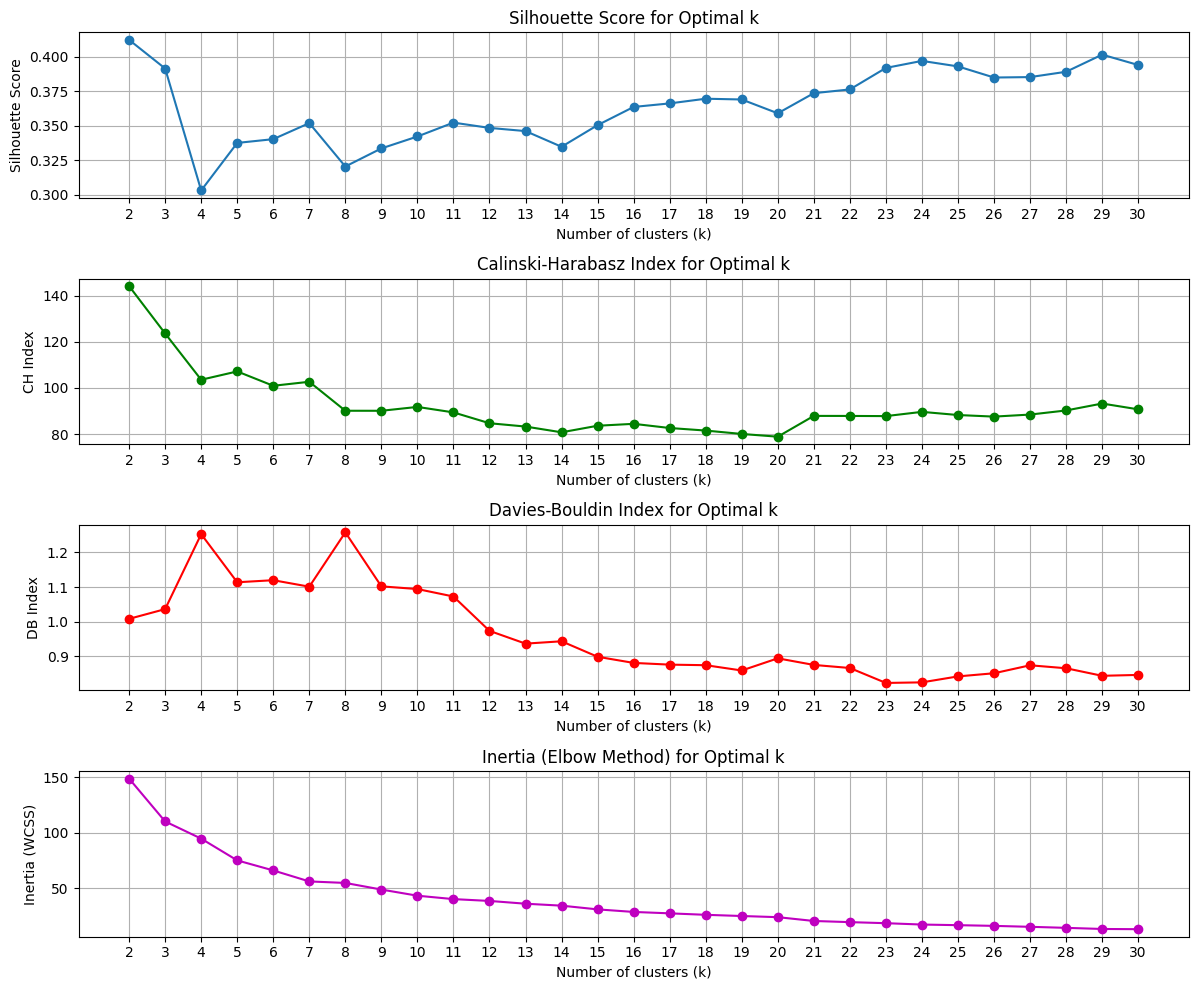


Kneedle 알고리즘으로 찾은 Elbow 지점 k: 10

지표별 최적 k (참고):
  - 실루엣 점수 최대 k: 2
  - 칼린스키-하라바츠 지수 최대 k: 2
  - 데이비스-볼딘 지수 최소 k: 23
  - Inertia (Elbow): 그래프에서 '팔꿈치' 지점 확인 필요.

★★★ 최종 k 선택 가이드 ★★★
1. 위 지표들과 그래프(특히 Elbow)를 종합적으로 검토합니다.
2. k=2와 같이 너무 작거나, 지표들이 극단적으로 다른 k를 제안하는 경우, 단일 지표만 맹신하지 않습니다.
3. 몇 개의 후보 k 값(예: DB가 제안한 23 근처, Elbow 지점 근처, 다른 지표들이 비교적 양호한 중간 값 등)을 선택합니다.
4. 선택된 후보 k 값 각각에 대해 BERTopic(..., hdbscan_model=KMeans(n_clusters=k), ...)를 실행하여 실제 토픽 결과(키워드 등)를 얻습니다.
5. 생성된 토픽들의 의미론적 명확성, 분별력, 유용성 등을 **직접 검토하고 평가**하여 최종 k를 결정합니다.
   (이 과정이 가장 중요할 수 있습니다!)


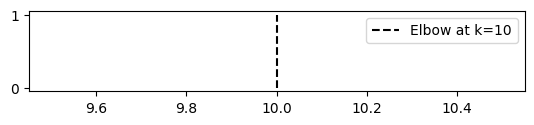

In [6]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
from kneed import KneeLocator
import time

abstracts = df['abstract'].tolist()

embedding_model = SentenceTransformer('all-mpnet-base-v2')
umap_model = umap.UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=1004)
embeddings = embedding_model.encode(abstracts)
reduced_embeddings = umap_model.fit_transform(embeddings)
print(f"UMAP 축소된 데이터 형태: {reduced_embeddings.shape}")


k_range = range(2, 31)

silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []
inertia_scores = [] # Inertia 점수 저장을 위한 리스트 추가

start_time = time.time()

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(reduced_embeddings)

    if len(set(cluster_labels)) < 2:
        silhouette_scores.append(np.nan)
        calinski_harabasz_scores.append(np.nan)
        davies_bouldin_scores.append(np.nan)
        inertia_scores.append(np.nan)
        continue

    silhouette_avg = silhouette_score(reduced_embeddings, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    ch_score = calinski_harabasz_score(reduced_embeddings, cluster_labels)
    calinski_harabasz_scores.append(ch_score)
    db_score = davies_bouldin_score(reduced_embeddings, cluster_labels)
    davies_bouldin_scores.append(db_score)
    inertia = kmeans.inertia_
    inertia_scores.append(inertia)

    if k % 5 == 0:
         # Inertia 값도 출력에 추가
        print(f"  k={k}: 실루엣={silhouette_avg:.3f}, CH={ch_score:.0f}, DB={db_score:.3f}, Inertia={inertia:.0f}")

end_time = time.time()
print(f"k 값 탐색 완료. 소요 시간: {end_time - start_time:.2f} 초")

# --- 결과 시각화 (Matplotlib 사용) ---
# 시각화 라이브러리 설치 필요: pip install matplotlib
plt.figure(figsize=(12, 10))

# 실루엣 점수 그래프
plt.subplot(4, 1, 1)
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)
plt.grid(True)

# 칼린스키-하라바츠 점수 그래프
plt.subplot(4, 1, 2)
plt.plot(k_range, calinski_harabasz_scores, marker='o', color='g')
plt.title('Calinski-Harabasz Index for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('CH Index')
plt.xticks(k_range)
plt.grid(True)

# 데이비스-볼딘 점수 그래프
plt.subplot(4, 1, 3)
plt.plot(k_range, davies_bouldin_scores, marker='o', color='r')
plt.title('Davies-Bouldin Index for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('DB Index')
plt.xticks(k_range)
plt.grid(True)

# ★★★ Inertia (Elbow Method) 그래프 ★★★
plt.subplot(4, 1, 4)
plt.plot(k_range, inertia_scores, marker='o', color='m')
plt.title('Inertia (Elbow Method) for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.xticks(k_range)
plt.grid(True)

plt.tight_layout() # 그래프 간격 자동 조절
plt.show()

# ★★★ Kneedle를 사용하여 Elbow 지점 찾기 ★★★
# Inertia 점수 중 NaN 값이 있다면 제외하고 계산
valid_indices = ~np.isnan(inertia_scores)
valid_k_range = np.array(k_range)[valid_indices]
valid_inertia_scores = np.array(inertia_scores)[valid_indices]

if len(valid_k_range) >= 2: # Kneedle은 최소 2개 포인트 필요
    try:
        kneedle = KneeLocator(
            valid_k_range,          # x 값 (k 범위)
            valid_inertia_scores,   # y 값 (Inertia 점수)
            curve='convex',         # 곡선 형태 (볼록)
            direction='decreasing', # 방향 (감소)
            S=1.0                   # 민감도 (기본값 1.0, 필요시 조절)
        )
        elbow_k = kneedle.elbow

        # 찾은 엘보우 지점을 그래프에 표시 (선택 사항)
        if elbow_k:
            print(f"\nKneedle 알고리즘으로 찾은 Elbow 지점 k: {elbow_k}")
            plt.subplot(4, 1, 4) # Inertia 그래프 선택
            plt.vlines(elbow_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', color='k', label=f'Elbow at k={elbow_k}')
            plt.legend()
        else:
            print("\nKneedle 알고리즘이 명확한 Elbow 지점을 찾지 못했습니다.")
            elbow_k = 'N/A' # 명시적으로 N/A 처리

    except Exception as e:
        print(f"\nKneedle 실행 중 오류 발생: {e}")
        elbow_k = 'N/A'
else:
    print("\nInertia 점수가 충분하지 않아 Kneedle을 실행할 수 없습니다.")
    elbow_k = 'N/A'

# --- 최적의 k 값 선택 (가이드라인) ---
# 실루엣 점수와 칼린스키-하라바츠 점수는 최대가 되는 지점,
# 데이비스-볼딘 점수는 최소가 되는 지점을 찾습니다.
# 여러 지표가 동시에 최적인 k 값이 없을 수도 있습니다.
# 그래프의 '엘보우(elbow)' 지점이나, 점수가 급격히 변하는 지점,
# 또는 여러 지표가 비교적 좋은 값을 보이는 k를 종합적으로 고려하여 선택합니다.
# 예: 실루엣 점수가 가장 높고 DB 점수도 낮은 k 값 선택

# 최적 k 값 예시 찾기 (참고용, 실제로는 그래프 보고 판단)
best_k_silhouette = k_range[np.nanargmax(silhouette_scores)] if not np.all(np.isnan(silhouette_scores)) else 'N/A'
best_k_ch = k_range[np.nanargmax(calinski_harabasz_scores)] if not np.all(np.isnan(calinski_harabasz_scores)) else 'N/A'
best_k_db = k_range[np.nanargmin(davies_bouldin_scores)] if not np.all(np.isnan(davies_bouldin_scores)) else 'N/A'

print(f"\n지표별 최적 k (참고):")
print(f"  - 실루엣 점수 최대 k: {best_k_silhouette}")
print(f"  - 칼린스키-하라바츠 지수 최대 k: {best_k_ch}")
print(f"  - 데이비스-볼딘 지수 최소 k: {best_k_db}")
print("  - Inertia (Elbow): 그래프에서 '팔꿈치' 지점 확인 필요.")

print("\n★★★ 최종 k 선택 가이드 ★★★")
print("1. 위 지표들과 그래프(특히 Elbow)를 종합적으로 검토합니다.")
print("2. k=2와 같이 너무 작거나, 지표들이 극단적으로 다른 k를 제안하는 경우, 단일 지표만 맹신하지 않습니다.")
print("3. 몇 개의 후보 k 값(예: DB가 제안한 23 근처, Elbow 지점 근처, 다른 지표들이 비교적 양호한 중간 값 등)을 선택합니다.")
print("4. 선택된 후보 k 값 각각에 대해 BERTopic(..., hdbscan_model=KMeans(n_clusters=k), ...)를 실행하여 실제 토픽 결과(키워드 등)를 얻습니다.")
print("5. 생성된 토픽들의 의미론적 명확성, 분별력, 유용성 등을 **직접 검토하고 평가**하여 최종 k를 결정합니다.")
print("   (이 과정이 가장 중요할 수 있습니다!)")

In [7]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import time

# --- 이전 단계에서 준비된 변수들 ---
# reduced_embeddings: UMAP으로 차원 축소된 임베딩 데이터 (numpy array)
# df: 원본 데이터프레임 (초록 및 기타 정보 포함)

optimal_k = elbow_k
kmeans_model = KMeans(n_clusters=optimal_k, random_state=1004, n_init='auto') # 이전 평가와 동일한 random_state
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=kmeans_model,
    language="english",
    calculate_probabilities=False, # K-Means는 확률 계산 미지원
    verbose=True
)

try:
    topics = topic_model.fit_transform(abstracts)[0]
    probs = None # K-Means는 확률 반환 안 함
except Exception as e:
    print(f"BERTopic 실행 중 오류 발생: {e}")
    # 필요시 이전 오류 해결 방법 적용
    exit()

df[f'bertopic_kmeans_k{optimal_k}'] = topics # 컬럼 이름 명확히
topic_info = topic_model.get_topic_info()

print("\n토픽 정보 요약 (BERTopic + K-Means k=10):")
print(topic_info)
# K-Means는 -1(노이즈) 토픽을 만들지 않으므로, 0부터 9까지 10개 토픽 생성됨
print(f"\n총 {len(topic_info)}개의 토픽이 생성되었습니다 (0 ~ {optimal_k-1}).")

print("\n상위 토픽 키워드 예시 (Top 5):")
num_topics_to_show = min(5, optimal_k) # 최대 5개 또는 전체 토픽 수
for topic_id in range(num_topics_to_show):
    topic_keywords = topic_model.get_topic(topic_id)
    if topic_keywords:
        print(f"Topic {topic_id}: ", [word for word, score in topic_keywords[:10]])
    else:
        print(f"Topic {topic_id}: 키워드를 찾을 수 없음")

2025-05-14 12:39:40,832 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

2025-05-14 12:39:42,459 - BERTopic - Embedding - Completed ✓
2025-05-14 12:39:42,460 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-14 12:39:42,813 - BERTopic - Dimensionality - Completed ✓
2025-05-14 12:39:42,814 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-14 12:39:42,816 - BERTopic - Cluster - Completed ✓
2025-05-14 12:39:42,818 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-14 12:39:42,832 - BERTopic - Representation - Completed ✓



토픽 정보 요약 (BERTopic + K-Means k=10):
   Topic  Count                    Name  \
0      0     25         0_the_and_in_of   
1      1     22   1_the_learning_and_of   
2      2     17         2_of_the_and_to   
3      3     16    3_the_to_teachers_of   
4      4     16    4_the_science_of_and   
5      5     15         5_and_of_the_to   
6      6     15         6_and_of_the_to   
7      7     13         7_the_of_in_and   
8      8     12         8_and_the_to_of   
9      9      6  9_the_students_and_cbl   

                                      Representation  \
0  [the, and, in, of, to, students, with, science...   
1  [the, learning, and, of, to, in, students, on,...   
2  [of, the, and, to, in, is, skills, brain, lear...   
3  [the, to, teachers, of, in, and, neuroscience,...   
4  [the, science, of, and, students, in, that, to...   
5  [and, of, the, to, in, educational, research, ...   
6  [and, of, the, to, in, education, learning, th...   
7  [the, of, in, and, neuroscience, that,

In [8]:
df.bertopic_kmeans_k10.value_counts()

bertopic_kmeans_k10
0    25
1    22
2    17
3    16
4    16
5    15
6    15
7    13
8    12
9     6
Name: count, dtype: int64

In [9]:
df.to_excel('Data/wos_neuro_r2.xlsx')

In [44]:
import re
from typing import List, Optional, Tuple
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
import torch

class LongTextGrammarCorrector:
    """긴 텍스트의 문법 및 띄어쓰기를 교정하는 클래스"""
    
    def __init__(self, model_name: str = "vennify/t5-base-grammar-correction", 
                 max_chunk_length: int = 256,  # 청크 크기 감소
                 device: Optional[str] = None):
        """
        Parameters:
        - model_name: 사용할 Hugging Face 모델 이름
        - max_chunk_length: 각 청크의 최대 토큰 길이 (더 작게 설정)
        - device: 'cuda' 또는 'cpu' (None일 경우 자동으로 선택)
        """
        self.model_name = model_name
        self.max_chunk_length = max_chunk_length
        
        # 디바이스 설정
        if device is None:
            self.device = 0 if torch.cuda.is_available() else -1
        else:
            self.device = 0 if device == 'cuda' else -1
        
        # 모델과 토크나이저 로드
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
        
        # 파이프라인 생성
        self.corrector = pipeline(
            "text2text-generation", 
            model=self.model,
            tokenizer=self.tokenizer,
            device=self.device
        )
        
        # 모델의 최대 길이 설정
        self.model_max_length = self.tokenizer.model_max_length
        if self.model_max_length > 512:
            self.model_max_length = 512
    
    def split_text_by_sentences(self, text: str) -> List[str]:
        """텍스트를 문장 단위로 분할합니다."""
        # 간단한 문장 분리 방법 사용
        # 마침표, 느낌표, 물음표 뒤에 공백이 오는 경우를 기준으로 분할
        sentences = re.split(r'([.!?]+)\s+', text)
        
        # 분할된 결과를 재조합
        result = []
        i = 0
        while i < len(sentences):
            if i + 1 < len(sentences) and sentences[i+1] in '.!?':
                # 문장과 구두점을 합침
                result.append(sentences[i] + sentences[i+1])
                i += 2
            else:
                if sentences[i].strip():
                    result.append(sentences[i])
                i += 1
        
        # 빈 문장 제거
        result = [s.strip() for s in result if s.strip()]
        
        # 일부 문장이 구분자 없이 끝날 수 있음
        if not result and text.strip():
            result = [text.strip()]
        
        return result
    
    def create_chunks_preserving_sentences(self, text: str) -> List[str]:
        """
        문장을 보존하면서 텍스트를 청크로 나눕니다.
        """
        sentences = self.split_text_by_sentences(text)
        chunks = []
        current_chunk = ""
        
        for sentence in sentences:
            # 문장의 토큰 수 계산
            sentence_tokens = len(self.tokenizer.encode(sentence, add_special_tokens=False))
            current_tokens = len(self.tokenizer.encode(current_chunk, add_special_tokens=False))
            
            # 단일 문장이 너무 긴 경우
            if sentence_tokens > self.max_chunk_length:
                # 현재 청크가 있으면 먼저 저장
                if current_chunk:
                    chunks.append(current_chunk.strip())
                    current_chunk = ""
                
                # 긴 문장을 단어 단위로 분할
                words = sentence.split()
                temp_chunk = ""
                
                for word in words:
                    test_chunk = temp_chunk + " " + word if temp_chunk else word
                    test_tokens = len(self.tokenizer.encode(test_chunk, add_special_tokens=False))
                    
                    if test_tokens > self.max_chunk_length:
                        if temp_chunk:
                            chunks.append(temp_chunk.strip())
                        temp_chunk = word
                    else:
                        temp_chunk = test_chunk
                
                if temp_chunk:
                    chunks.append(temp_chunk.strip())
            
            # 현재 청크에 문장 추가 가능한 경우
            elif current_tokens + sentence_tokens <= self.max_chunk_length:
                current_chunk = current_chunk + " " + sentence if current_chunk else sentence
            
            # 현재 청크가 가득 찬 경우
            else:
                chunks.append(current_chunk.strip())
                current_chunk = sentence
        
        # 마지막 청크 추가
        if current_chunk:
            chunks.append(current_chunk.strip())
        
        return chunks
    
    def correct_chunk(self, chunk: str, num_beams: int = 5) -> str:
        """
        단일 텍스트 청크를 교정합니다.
        길이 보존을 위해 개선된 방법을 사용합니다.
        """
        # 모델에 따라 적절한 프롬프트 형식 사용
        if "grammar-correction" in self.model_name.lower():
            input_text = f"grammar: {chunk}"
        elif "sentence-doctor" in self.model_name.lower():
            input_text = f"repair_sentence: {chunk} context: {{}} </s>"
        else:
            input_text = chunk
        
        # 교정 수행 (길이 보존을 위한 파라미터 조정)
        try:
            result = self.corrector(
                input_text,
                max_length=len(chunk) + 50,  # 원본 길이보다 약간 길게 설정
                min_length=int(len(chunk) * 0.8),  # 최소 길이 설정
                num_beams=num_beams,
                early_stopping=False,  # 더 완전한 출력을 위해 False로 설정
                no_repeat_ngram_size=3,
                length_penalty=1.0,  # 길이 페널티 조정
                temperature=1.0
            )
            
            corrected = result[0]['generated_text']
            
            # 교정된 텍스트가 너무 짧으면 원본 반환
            if len(corrected) < len(chunk) * 0.5:
                print(f"경고: 교정된 텍스트가 너무 짧습니다. 원본 유지.")
                return chunk
                
            return corrected
            
        except Exception as e:
            print(f"청크 교정 중 오류 발생: {e}")
            return chunk
    
    def correct_long_text(self, text: str, num_beams: int = 5, 
                        show_progress: bool = True,
                        preserve_length: bool = True) -> str:
        """
        긴 텍스트를 청크로 나누어 교정한 후 합칩니다.
        
        Parameters:
        - text: 교정할 전체 텍스트
        - num_beams: 빔 서치에 사용할 빔 수
        - show_progress: 진행 상황 출력 여부
        - preserve_length: 길이 보존 옵션
        
        Returns:
        - 교정된 전체 텍스트
        """
        if not text.strip():
            return text
        
        # 원본 텍스트 길이 저장
        original_length = len(text)
        
        # 텍스트를 청크로 분할
        chunks = self.create_chunks_preserving_sentences(text)
        
        if show_progress:
            print(f"텍스트를 {len(chunks)}개의 청크로 분할했습니다.")
            print(f"원본 텍스트 길이: {original_length}")
        
        # 각 청크 교정
        corrected_chunks = []
        for i, chunk in enumerate(chunks):
            if show_progress:
                print(f"청크 {i+1}/{len(chunks)} 교정 중... (길이: {len(chunk)})")
            
            corrected_chunk = self.correct_chunk(chunk, num_beams)
            corrected_chunks.append(corrected_chunk)
            
            if show_progress:
                print(f"  교정 후 길이: {len(corrected_chunk)}")
        
        # 교정된 청크들을 합치기
        corrected_text = " ".join(corrected_chunks)
        
        # 중복 공백 제거 (너무 공격적이지 않게)
        corrected_text = re.sub(r'  +', ' ', corrected_text)  # 2개 이상의 공백만 제거
        corrected_text = corrected_text.strip()
        
        if show_progress:
            print(f"교정 완료! 최종 텍스트 길이: {len(corrected_text)}")
            print(f"길이 보존율: {len(corrected_text)/original_length*100:.1f}%")
        
        return corrected_text
    
    def correct_with_fallback(self, text: str, num_beams: int = 5) -> str:
        """
        교정 시도 후 길이가 너무 줄어들면 더 작은 청크로 재시도합니다.
        """
        # 첫 번째 시도
        corrected = self.correct_long_text(text, num_beams, show_progress=False)
        
        # 길이가 50% 미만으로 줄어든 경우
        if len(corrected) < len(text) * 0.5:
            print("길이가 너무 많이 줄어들었습니다. 더 작은 청크로 재시도합니다.")
            # 더 작은 청크 크기로 재시도
            self.max_chunk_length = self.max_chunk_length // 2
            corrected = self.correct_long_text(text, num_beams, show_progress=False)
        
        return corrected

In [45]:
corrector = LongTextGrammarCorrector(
    model_name="vennify/t5-base-grammar-correction",
    max_chunk_length=150  # 더 작게 설정
)
corrected_text = corrector.correct_long_text(df.loc[0, 'text'], num_beams=5)

텍스트를 55개의 청크로 분할했습니다.
원본 텍스트 길이: 32767
청크 1/55 교정 중... (길이: 264)
  교정 후 길이: 795
청크 2/55 교정 중... (길이: 851)
  교정 후 길이: 1482
청크 3/55 교정 중... (길이: 546)
  교정 후 길이: 939
청크 4/55 교정 중... (길이: 512)
  교정 후 길이: 1021
청크 5/55 교정 중... (길이: 535)
  교정 후 길이: 1201
청크 6/55 교정 중... (길이: 643)
  교정 후 길이: 1222
청크 7/55 교정 중... (길이: 708)
  교정 후 길이: 1374
청크 8/55 교정 중... (길이: 568)
  교정 후 길이: 1030
청크 9/55 교정 중... (길이: 467)
  교정 후 길이: 886
청크 10/55 교정 중... (길이: 712)
  교정 후 길이: 1271
청크 11/55 교정 중... (길이: 623)
  교정 후 길이: 1123
청크 12/55 교정 중... (길이: 734)
  교정 후 길이: 1055
청크 13/55 교정 중... (길이: 671)
  교정 후 길이: 1181
청크 14/55 교정 중... (길이: 410)
  교정 후 길이: 824
청크 15/55 교정 중... (길이: 647)


KeyboardInterrupt: 

In [41]:
len(df.loc[0, 'text']), len(corrected_text)

(32767, 9253)

### KeyBERT를 이용한 주요어 추출, 생성

In [27]:
from keybert import KeyBERT
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import re

# Function to split long text into chunks
def chunk_text(text, max_length=10000):
    words = text.split()
    chunks = []
    current = []
    length = 0
    for w in words:
        current.append(w)
        length += len(w) + 1
        if length >= max_length:
            chunks.append(" ".join(current))
            current = []
            length = 0
    if current:
        chunks.append(" ".join(current))
    return chunks

# Main extraction function with explicit parameters
def extract_top_keywords(
    document,
    top_n=10,
    chunk_size=10000,
    min_word=1,
    max_word=3,
    stop_words='english',
    use_mmr=False,
    diversity=0.5
):
    # Initialize KeyBERT model
    kw_model = KeyBERT('distilbert-base-nli-mean-tokens')

    # Split document into manageable chunks
    chunks = chunk_text(document, max_length=chunk_size)

    # Collect keywords from each chunk
    all_keywords = []
    for chunk in chunks:
        for i in range(min_word, max_word+1):
            keywords = kw_model.extract_keywords(
                chunk,
                keyphrase_ngram_range=(i, i),
                stop_words=stop_words,
                top_n=top_n,
                use_mmr=use_mmr,
                diversity=diversity
            )
            all_keywords.extend([kw[0] for kw in keywords])

    # Aggregate and score keywords by frequency
    unique, counts = np.unique(all_keywords, return_counts=True)
    freq = list(zip(unique, counts))
    # Sort by frequency descending
    freq.sort(key=lambda x: x[1], reverse=True)

    # Filter out phrases starting with a digit
    filtered = [(kw, count) for kw, count in freq if not re.match(r"^\d", kw)]

    # Return top N keywords
    return [kw for kw, _ in filtered[:top_n]]

In [37]:
for i in range(len(df)):
    # 키워드가 없는 경우에만 동작하도록 설정
    if not pd.isna(df.loc[i, 'keywords']):
        continue

    print(f"Running for {i}")
    text = df.loc[i, 'text'].lower()

    keywords = extract_top_keywords(
        text,
        top_n=10,
        chunk_size=10000,
        min_word=1,
        max_word=3,
        stop_words='english',
        use_mmr=True,
        diversity=0.3
    )
    print("Top 10 Keywords:", keywords)

Running for 2
Top 10 Keywords: ['neuroscience', 'neuroimaging', 'science', 'seoulnationaluniversity', 'seoulnationaluniversity wileyonline', 'acc activated interestingly', 'activation experts', 'activationtheapplicablecreativecommonslicense1751228x', 'activationtheapplicablecreativecommonslicense1751228x 2020', 'activationtheapplicablecreativecommonslicense1751228x 2020 ﬁndings']
Running for 7
Top 10 Keywords: ['neuroscience', 'neuroscience teacher', 'oaarticlesaregovernedbytheapplicablecreativecommonslicense1751228x', 'teachers', 'classrooms', 'neuromyths', 'psychology', 'teacher', 'academic', 'acquired neuroscience']
Running for 8
Top 10 Keywords: ['oaarticlesaregovernedbytheapplicablecreativecommonslicense1751228x', 'chemistry students', 'educational neuroscience', 'neuroscience', 'psychology', 'adapting', 'adapting science', 'added neuroscience', 'added neuroscience neuroscien', 'adding neuroscientiﬁc']
Running for 9
Top 10 Keywords: ['neurological', 'neurosciences', 'neural', 'neu

In [10]:
import pandas as pd

df = pd.read_excel('Data/wos_neuro_r2.xlsx', index_col=0)

In [7]:
optimal_k = 10

In [8]:
from openai import OpenAI
from dotenv import load_dotenv
import os
import time
import json

load_dotenv()
client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))

tools = [
    {
        "type": "function",
        "function": {
            "name": "summarizer",
            "description": "Labeling for each cluster and its summary",
            "parameters": {
                "type": "object",
                "properties": {},      # 나중에 여기에 추가
                "required": []         # 미리 만들어 두면 좋습니다
            },
        }
    },
]

# 2) cluster 개수만큼 properties와 required 채우기
n_clusters = optimal_k
tool = tools[0]["function"]["parameters"]   # 여기를 주목!

for i in range(1, n_clusters + 1):
    tool["properties"][f"title {i}"] = {
        "type": "string",
        "description": f"Title of Cluster {i}"
    }
    tool["properties"][f"summary of Cluster {i}"] = {
        "type": "string",
        "description": f"Result of Cluster Summary {i}"
    }

# 3) required 항목 추가
tool["required"] = [f"title {i}" for i in range(1, n_clusters+1)] \
                 + [f"summary {i}" for i in range(1, n_clusters+1)]
tools[0]["function"]["parameters"] = tool

In [10]:
tools

[{'type': 'function',
  'function': {'name': 'summarizer',
   'description': 'Labeling for each cluster and its summary',
   'parameters': {'type': 'object',
    'properties': {'title 1': {'type': 'string',
      'description': 'Title of Cluster 1'},
     'summary of Cluster 1': {'type': 'string',
      'description': 'Result of Cluster Summary 1'},
     'title 2': {'type': 'string', 'description': 'Title of Cluster 2'},
     'summary of Cluster 2': {'type': 'string',
      'description': 'Result of Cluster Summary 2'},
     'title 3': {'type': 'string', 'description': 'Title of Cluster 3'},
     'summary of Cluster 3': {'type': 'string',
      'description': 'Result of Cluster Summary 3'},
     'title 4': {'type': 'string', 'description': 'Title of Cluster 4'},
     'summary of Cluster 4': {'type': 'string',
      'description': 'Result of Cluster Summary 4'},
     'title 5': {'type': 'string', 'description': 'Title of Cluster 5'},
     'summary of Cluster 5': {'type': 'string',
     

In [34]:
%%time

df_new = pd.DataFrame(columns=['Title', 'Summary'])

for i in range(len(df.bertopic_kmeans_k10.unique())):   

    print(f"::::: Cluster No. {i+1} :::::")
    
    messages = []
    messages.append({"role": "system", "content": "너는 텍스트 분석의 전문가야. 텍스트에 기반해서 정확하고 논리적인 내용을 전달해 줘."})

    cluster_texts = df[df['bertopic_kmeans_k10'] == i]['abstract'].tolist()
    joined_text = " ".join(cluster_texts)
    
    query = "다음은 신경과학(Neuroscience)과 과학교육(Science Education)의 연관성을 다루는 연구 초록들을 클러스터링한 결과입니다. "
    query += "클러스터에 대한 텍스트는 다음과 같습니다.\n"
    query += "## Text ##\n"
    query += joined_text
    query += "\n\n"
    query += "다음 두 가지 핵심 측면을 식별하는 것이 주요 작업입니다:\n"
    query += "1.  **과학교육(Science Education) 내에서의 구체적인 초점:** (예: 개념 변화(conceptual change), 탐구 학습(inquiry learning), 학생 동기(motivation), 특정 과목 학습(물리/생물 등), 평가(assessment), 교사 교육(teacher training), 교육과정 개발(curriculum development), 학습 장애(learning difficulties) 등)\n"
    query += "2.  **적용되거나 논의되는 구체적인 신경과학(Neuroscience) 관점 또는 방법:** (예: fMRI 연구 결과, EEG/ERP 분석, 인지 기능(작업 기억/주의력 등), 신경 가소성(neural plasticity), 체화된 인지(embodied cognition), 특정 뇌 영역(전두엽 피질/해마 등), 뇌 유형 비교(brain types), 윤리적 고려사항(ethical considerations), 특정 신경 전달 물질(neurotransmitters) 등)\n"
    query += "이 두 가지 식별된 측면을 바탕으로, 클러스터에 대한 **간결하고(concise), 구체적이며(specific), 설명적인(descriptive) 제목(레이블)**을 생성해 주십시오. 이 제목은 해당 클러스터의 **독특한 교차점**(과학교육 초점 + 신경과학 관점)을 명확히 강조하여 다른 클러스터와 **차별화(differentiate)**될 수 있어야 합니다.\n"
    query += "또한, 해당 클러스터의 초록들에서 논의되는 주요 내용이나 연구 결과에 대한 **간략한 요약**(300자 이내)도 함께 제시해 주십시오.\n"
    query += "클러스터에 대한 결과를 **JSON 형식**으로 반환해 주십시오.\nTitle:\nSummary:\n와 같은 형식으로 제공해 주세요."   
    
    messages.append({"role": "user", "content": query})
        
    success = False  # 성공 여부 플래그
    retries = 2      # 재시도 횟수 제한
    attempt = 0      # 현재 시도 횟수
    
    while not success and attempt < retries:
        try:
            resp = client.chat.completions.create(
                model="gpt-4o",
                messages=messages,
            )
            # JSON 파싱 시도
            result = resp.choices[0].message.content
            clean = (result
                     .replace('```json', '')
                     .replace('```', '')
                     .strip())
            data = json.loads(clean)
            print(data)   

            df_new.loc[len(df_new)] = data
            
            success = True  # 성공 시 플래그 업데이트
        except json.JSONDecodeError as e:
            print(f"JSON Decode Error: {e}. Retrying...")
            attempt += 1  # 시도 횟수 증가
        except Exception as e:
            print(f"Unexpected Error: {e}. Retrying...")
            attempt += 1  # 시도 횟수 증가
    
    if not success:
        print("Failed to process the request after multiple attempts.:", i)

::::: Cluster No. 1 :::::
{'Title': 'Neuroscience-Informed Conceptual Change in Science Education', 'Summary': 'This cluster explores the integration of educational neuroscience into understanding conceptual change within science education. It highlights challenges in bridging neuroscience concept learning, focusing on categories, with science education, which deals with causal systems. Key findings include the persistence of misconceptions and the role of cognitive processes such as memory, error detection, and inhibition. Advanced neuroimaging techniques and interdisciplinary collaboration are emphasized for enhancing science learning methods, with an emphasis on supporting dynamic, nonlinear cognitive processes and leveraging spatial ability for better STEM education outcomes.'}
::::: Cluster No. 2 :::::
{'Title': 'Integrating Neuroscience and Technology in Science Education: Applications and Insights', 'Summary': 'This cluster examines how neuroscience can inform and enhance scienc

In [35]:
for item in df_new.Title:
    print(item)

Neuroscience-Informed Conceptual Change in Science Education
Integrating Neuroscience and Technology in Science Education: Applications and Insights
Curriculum Innovation through Neuroeducation: Integrating Cognitive Science and Plasticity
Teacher Professional Development Through Neuroscience-Based Pedagogies
Empathizing and Systemizing Brain Types in Science Education and Learning Motivation
Bridging Educational Practice and Neuroscience: Challenges and Ethical Considerations
Transdisciplinary Integration of Biosocial Education and Neuroscience
Neuroeducational Theories in Math and Science Learning: Bridging Experimental Neuroscience and Classroom Application
Curriculum Development and Interactive Learning in Neuroscience Education
Integrative Learning Models in Science Education: Enhancing Academic Performance with Neuroscience-Informed Approaches


In [29]:
for item in df_new.Title:
    print(item)

Neuroscience and Conceptual Change in Science Learning
Neuroscience-Enhanced Learning: Integrating Brain Activity, Embodiment, and AI in Education
Neuroscientific Foundations and Implications for Educational Reform
Integrating Neuroscience in Educational Practice: Bridging the Gap Between Neurological Insights and Teaching Approaches
Neuroscience Perspectives on Science Learning: Cognitive Empathy and Systemizing Brain Types
Neuroscience in Education: Challenges, Innovations, and Ethical Considerations
Biosocial and Neuroeducational Approaches to Learning
Neuroeducational Integration: Bridging Cognitive Neuroscience with Educational Practice
Neuroscience Approaches to Enhancing Science Education: Whole Brain Learning and Cognitive Engagement
The Neuroscience of Integrated and Contextual Learning Models in Science Education


In [36]:
df_new.to_excel('Data/wos_neuro_category.xlsx')

In [37]:
df.columns

Index(['da', 'unique-id', 'web-of-science-index', 'doc-delivery-number',
       'journal-iso', 'usage-count-since-2013', 'usage-count-last-180-days',
       'times-cited', 'number-of-cited-references', 'cited-references',
       'researcherid-numbers', 'affiliations', 'author-email',
       'web-of-science-categories', 'research-areas', 'keywords-plus',
       'keywords', 'eissn', 'issn', 'doi', 'affiliation', 'language', 'type',
       'address', 'publisher', 'abstract', 'month', 'pages', 'number',
       'volume', 'year', 'journal', 'title', 'author', 'ENTRYTYPE', 'ID',
       'orcid-numbers', 'earlyaccessdate', 'funding-text',
       'funding-acknowledgement', 'oa', 'article-number', 'organization',
       'note', 'series', 'booktitle', 'editor', 'relevance', 'content',
       'feedback', 'text', 'bertopic_topic', 'kmeans_cluster',
       'bertopic_kmeans_k10'],
      dtype='object')

In [40]:
df.loc[0, 'cited-references']

'Ainley M., 2009, 8 ANN PYTH SCI COMP.\nAnderson O.R., 2009, Brunei International Journal of Mathematics and Science Education, V1, P1.\nAnderson OR, 2010, J SCI TEACH EDUC, V21, P683, DOI 10.1007/s10972-010-9211-2.\n{[}Anonymous], 2008, ED BRAIN ESSAYS NEUR.\nBaron-Cohen S, 2006, SCIENCE, V311, P952.\nBostrom N, 2009, SCI ENG ETHICS, V15, P311, DOI 10.1007/s11948-009-9142-5.\nBusatto GF, 1997, AM J PSYCHIAT, V154, P56.\nBuzan T., 1996, The Mind Map Book: How to Use Radiant Thinking to Maximize Your Brains Untapped Potential.\nCampbell SR, 2011, EDUC PHILOS THEORY, V43, P7, DOI 10.1111/j.1469-5812.2010.00701.x.\nCarew TJ, 2010, NEURON, V67, P685, DOI 10.1016/j.neuron.2010.08.028.\nChiu M.H., 2008, NAT ASS RES SCI TEAC.\nChiu M. H., 2008, 6 INT C CONC CHANG F.\nDavidson R.J., 2012, The emotional life of your brain: How its unique patterns affect the way you think, feel, and liveand How you can change them.\nDehaene S, 1999, SCIENCE, V284, P970, DOI 10.1126/science.284.5416.970.\nErk S, 

# 개별 글에서의 중요한 정보들을 추출하기

In [46]:
import pandas as pd

df = pd.read_excel('Data/wos_neuro_r2.xlsx', index_col=0)

In [47]:
from openai import OpenAI
from dotenv import load_dotenv
import os
import time
import json

load_dotenv()
client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))

tools = [
    {
        "type": "function",
        "function": {
            "name": "extract_info",
            "description": "Extract key information (research question, method, theory, finding, conclusion) from the given text.",
            "parameters": {
                "type": "object",
                "properties": {
                    "question": {
                        "type": "string",
                        "description": "Research question. In case of multiple questions, use ';' as the splitter.",
                    },
                    "method": {
                        "type": "string",
                        "description": "Research method",
                    },
                    "theory": {
                        "type": "string",
                        "description": "Key neuroscience theory based on the text",
                    },
                    "result": {
                        "type": "string",
                        "description": "Research finding",
                    },
                    "conclusion": {
                        "type": "string",
                        "description": "Conclusion",
                    },
                },
                "required": ["question", "method", "theory", "result", "conclusion"],
            },
        }
    },
]

In [52]:
df['complete'] = 0
df['question'] = None
df['method'] = None
df['theory'] = None
df['result'] = None
df['conclusion'] = None

In [55]:
for i in range(len(df)):
    title = df.loc[i, 'title']
    abstract = df.loc[i, 'abstract']

    if pd.isna(title) and pd.isna(abstract):
        print(f"모두 비어 있음: {i}")
        continue

    if df.loc[i, 'complete'] == 1:
        print(f"Already Done! at {i}")
        continue

    print(f"* Process start for {i}")
    
    query = "These are the title and the fulltext of a study dealing with science learning from the viewpoint of neuroscience.\n"
    query += f"Title: {title}\n"
    query += f"Text: {abstract}\n\n"
    query += "Extract research question, method, main theory relevant to neuroscience, result, and conclusion from the given article. "
    query += "If there are multiple research questions, separate each question with a semicolon (‘;’). "
    query += "Each element should not be over 200 words."

    messages = []
    messages.append({"role": "system", 
                     "content": "You are the expert of neuroscience and science education. Try to become rigorous and objective when you analyse."})
    messages.append({"role": "user", "content": query})

    success = False  # 성공 여부 플래그
    retries = 3      # 재시도 횟수 제한
    attempt = 0      # 현재 시도 횟수

    while not success and attempt < retries:
        try:
            resp = client.chat.completions.create(
                model="gpt-4o",
                messages=messages,
                tools=tools,
            )
            # JSON 파싱 시도
            result = resp.choices[0].message.tool_calls[0].function.arguments
            obj = json.loads(result)
            print(obj)

            df.loc[i, 'question'] = obj['question']
            df.loc[i, 'method'] = obj['method']
            df.loc[i, 'theory'] = obj['theory']
            df.loc[i, 'result'] = obj['result']
            df.loc[i, 'conclusion'] = obj['conclusion']
            df.loc[i, 'complete'] = 1
            
            success = True  # 성공 시 플래그 업데이트
        except json.JSONDecodeError as e:
            print(f"JSON Decode Error: {e}. Retrying...")
            attempt += 1  # 시도 횟수 증가
        except Exception as e:
            print(f"Unexpected Error: {e}. Retrying...")
            attempt += 1  # 시도 횟수 증가
    
    if not success:
        print("::::: Failed to process the request after multiple attempts.:", i)

    print(f"* Finished: index {i}")

print("FINALLY DONE!")    

Already Done! at 0
* Process start for 1
{'question': 'Can cognitive neuroscience provide a grounded basis for a science of learning?', 'method': 'Review of recent findings in cognitive neuroscience related to learning, focusing on mathematics and reading.', 'theory': 'Cognitive neuroscience as an emerging field that can contribute to theories of learning through empirical data.', 'result': 'Cognitive neuroscience, though still developing, offers valuable insights into learning processes, especially in mathematics and reading.', 'conclusion': 'Theories of learning should integrate findings from cognitive neuroscience, as it provides crucial empirical data essential for explaining learning processes.'}
* Finished: index 1
* Process start for 2
{'question': 'How can educational neuroscience inform conceptual change and science learning?', 'method': 'Review and integration of existing educational neuroscience studies on conceptual change and science learning', 'theory': 'Educational neuro

In [56]:
df.to_excel('Data/wos_neuro_f.xlsx')

In [57]:
import pandas as pd

df = pd.read_excel('Data/wos_neuro_f.xlsx', index_col=0)

<Figure size 640x480 with 0 Axes>

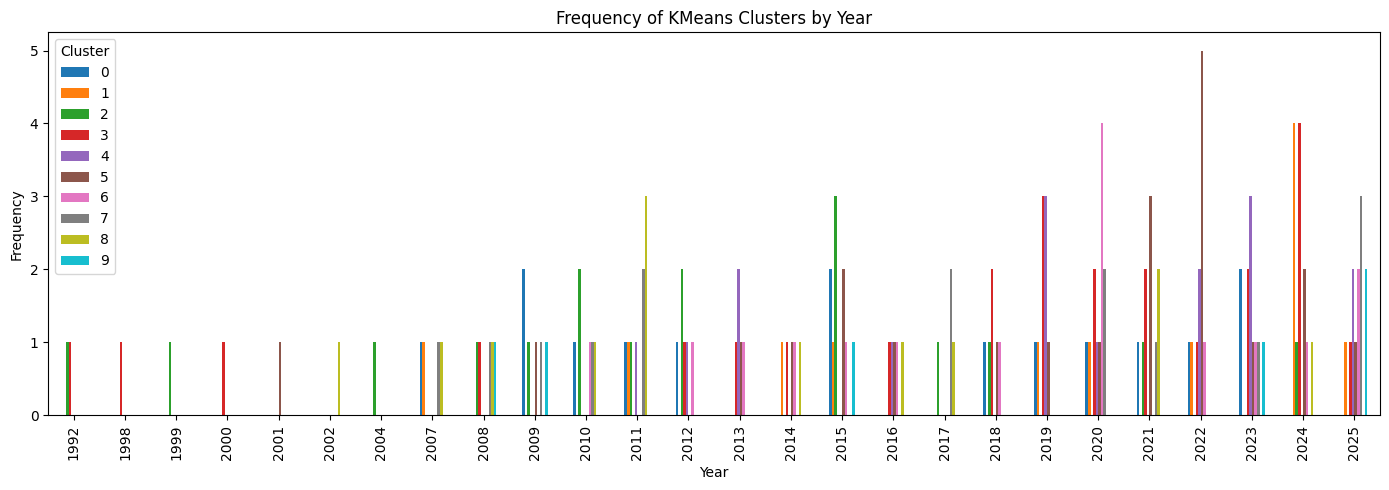

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) 년도별, 클러스터별 빈도 계산
freq = df.groupby(['year', 'kmeans_cluster']).size().unstack(fill_value=0)

# 2) 그래프 그리기 (라인 차트)
plt.figure()
freq.plot(figsize=(14, 5), kind='bar')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Frequency of KMeans Clusters by Year')
plt.legend(title='Cluster', loc='best')
plt.tight_layout()
plt.show()

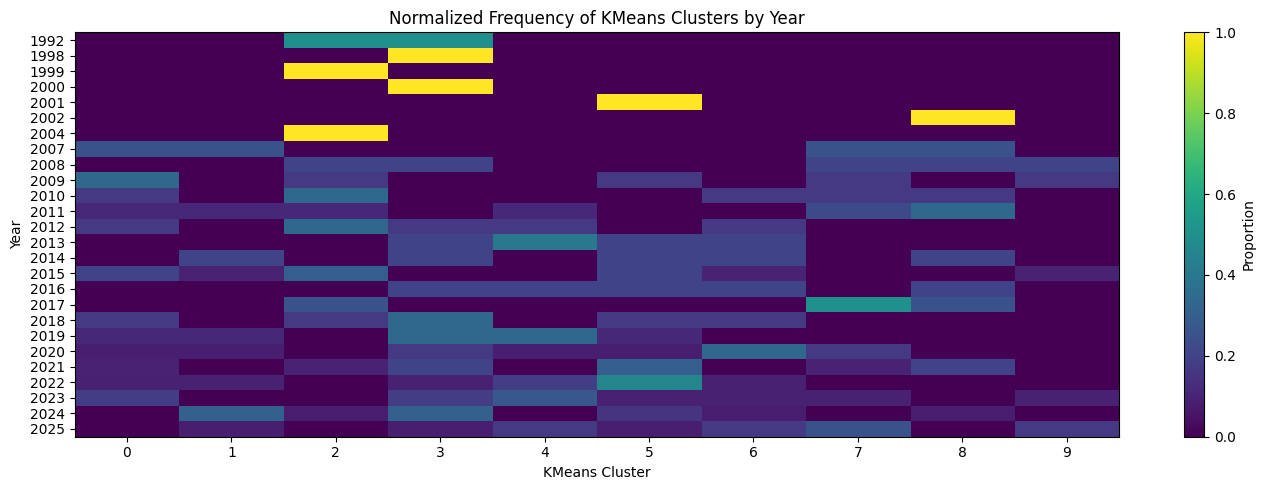

In [67]:
# 1) 원본 집계
freq = df.groupby(['year', 'kmeans_cluster']).size().unstack(fill_value=0)

# 2) 행별 정규화 (각 연도의 합이 1이 되도록)
normed = freq.div(freq.sum(axis=1), axis=0)

# 3) 히트맵 그리기
fig, ax = plt.subplots(figsize=(14,5))
im = ax.imshow(normed.values, aspect='auto')

ax.set_xticks(range(normed.shape[1]))
ax.set_xticklabels(normed.columns)
ax.set_yticks(range(normed.shape[0]))
ax.set_yticklabels(normed.index)

ax.set_xlabel('KMeans Cluster')
ax.set_ylabel('Year')
ax.set_title('Normalized Frequency of KMeans Clusters by Year')

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Proportion')

plt.tight_layout()
plt.show()

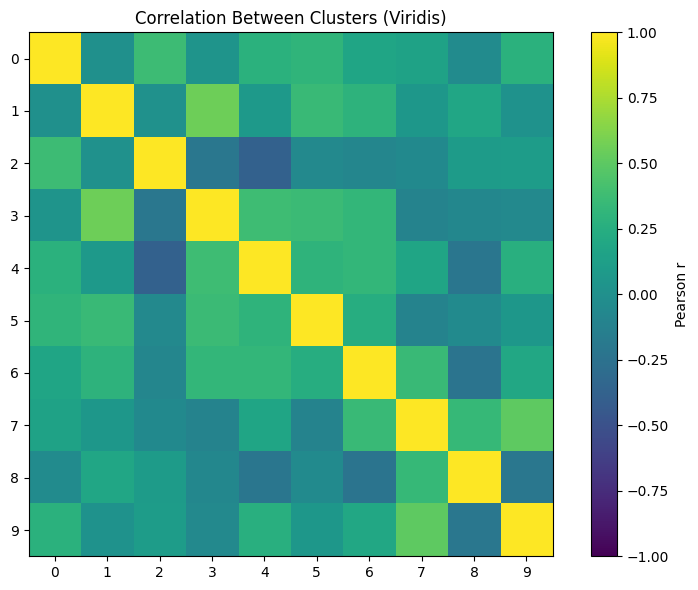

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

# (1) 연도×클러스터 빈도 집계
freq = df.groupby(['year', 'kmeans_cluster']).size().unstack(fill_value=0)

# (2) 클러스터 간 상관계수
corr = freq.corr()

# 예시 1: Viridis 컬러맵 (색상이 부드럽고 선명)
fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(corr.values, vmin=-1, vmax=1, cmap='viridis')
ax.set_xticks(range(corr.shape[1]))
ax.set_xticklabels(corr.columns)
ax.set_yticks(range(corr.shape[0]))
ax.set_yticklabels(corr.index)
ax.set_title('Correlation Between Clusters (Viridis)')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Pearson r')
plt.tight_layout()
plt.show()

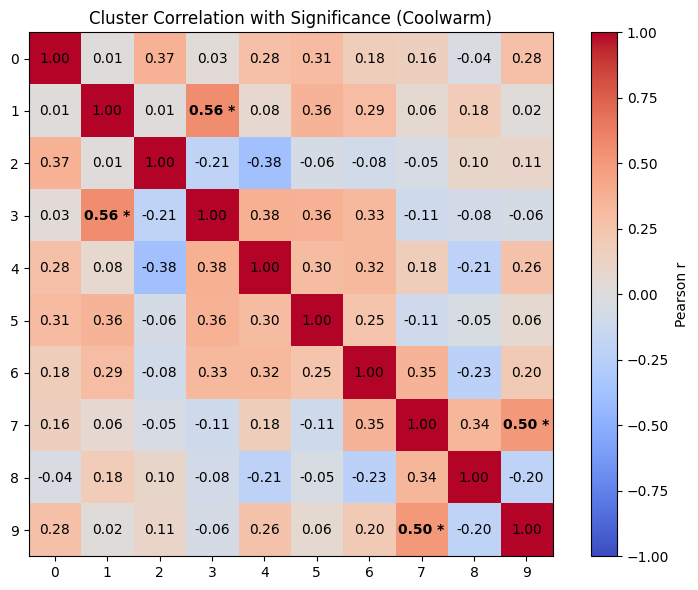

In [76]:
from scipy.stats import pearsonr

# 연도×클러스터 빈도 집계
freq = df.groupby(['year', 'kmeans_cluster']).size().unstack(fill_value=0)

# 클러스터 간 상관계수 & p-value 계산
clusters = freq.columns
n = freq.shape[0]
corr = freq.corr()
pvals = pd.DataFrame(np.zeros((len(clusters), len(clusters))), 
                     index=clusters, columns=clusters)

for i in clusters:
    for j in clusters:
        if i == j:
            pvals.loc[i, j] = 0.0
        else:
            r, p = pearsonr(freq[i], freq[j])
            pvals.loc[i, j] = p

# 히트맵 그리기 (coolwarm) 및 유의미한 상관관계 표시
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(corr.values, vmin=-1, vmax=1, cmap='coolwarm', aspect='equal')

# 축 설정
ax.set_xticks(range(len(clusters))); ax.set_xticklabels(clusters)
ax.set_yticks(range(len(clusters))); ax.set_yticklabels(clusters)

# 셀에 상관계수 텍스트 및 유의 표시
for i in range(len(clusters)):
    for j in range(len(clusters)):
        r_val = corr.values[i, j]
        p_val = pvals.values[i, j]
        text = f"{r_val:.2f}"
        if i != j and p_val < 0.05:
            text += " *"  # 유의미 표시
            weight = 'bold'
        else:
            weight = 'normal'
        ax.text(j, i, text, ha='center', va='center', fontsize=10, fontweight=weight)

ax.set_title('Cluster Correlation with Significance (Coolwarm)')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Pearson r')
plt.tight_layout()
plt.show()

In [82]:
df.columns

Index(['da', 'unique-id', 'web-of-science-index', 'doc-delivery-number',
       'journal-iso', 'usage-count-since-2013', 'usage-count-last-180-days',
       'times-cited', 'number-of-cited-references', 'cited-references',
       'researcherid-numbers', 'affiliations', 'author-email',
       'web-of-science-categories', 'research-areas', 'keywords-plus',
       'keywords', 'eissn', 'issn', 'doi', 'affiliation', 'language', 'type',
       'address', 'publisher', 'abstract', 'month', 'pages', 'number',
       'volume', 'year', 'journal', 'title', 'author', 'ENTRYTYPE', 'ID',
       'orcid-numbers', 'earlyaccessdate', 'funding-text',
       'funding-acknowledgement', 'oa', 'article-number', 'organization',
       'note', 'series', 'booktitle', 'editor', 'relevance', 'content',
       'feedback', 'text', 'bertopic_topic', 'kmeans_cluster',
       'bertopic_kmeans_k10', 'hdbscan_cluster', 'complete', 'question',
       'method', 'theory', 'result', 'conclusion'],
      dtype='object')

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

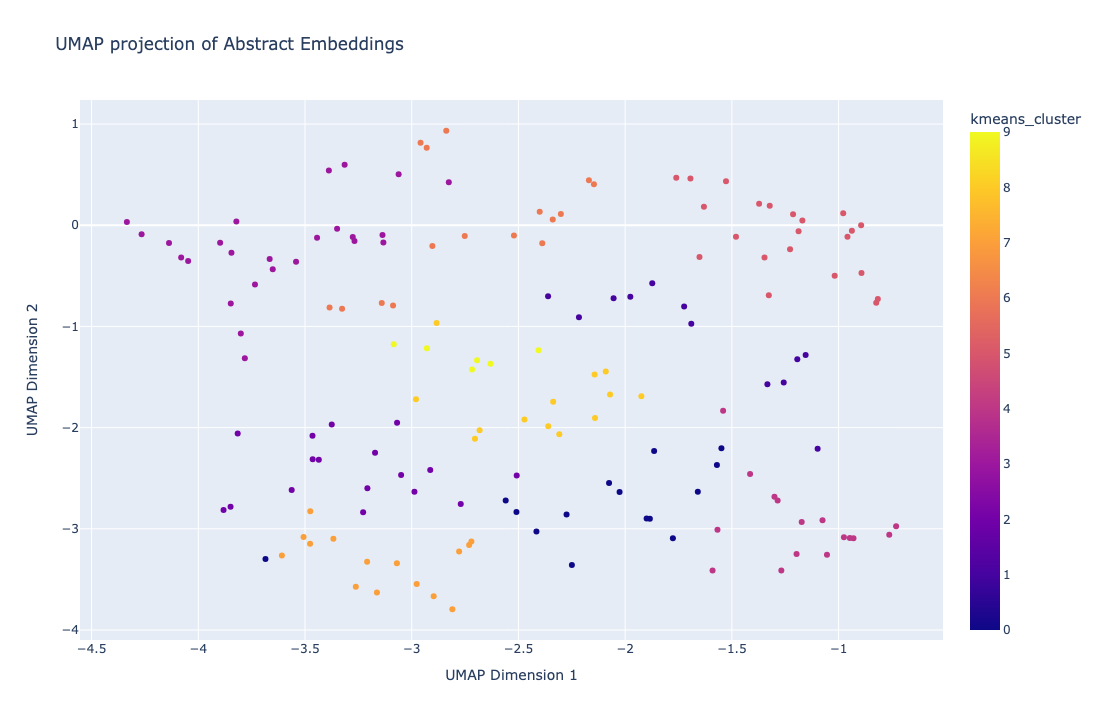

In [100]:
import pandas as pd
import plotly.express as px
from sentence_transformers import SentenceTransformer
import umap

embedding_model = SentenceTransformer('all-mpnet-base-v2')
umap_model = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42)

# 1. Compute embeddings for abstracts
embeddings = embedding_model.encode(
    df['abstract'].str.lower().tolist(),
    show_progress_bar=True
)

# 2. Apply UMAP
umap_embeddings = umap_model.fit_transform(embeddings)
# create a DataFrame for the reduced dimensions
umap_df = pd.DataFrame(
    umap_embeddings,
    columns=[f"UMAP_{i+1}" for i in range(umap_embeddings.shape[1])]
)

# 3. Merge with original dataframe
plot_df = pd.concat([df.reset_index(drop=True), umap_df], axis=1)

# 4. Plot with Plotly
fig = px.scatter(
    plot_df,
    x='UMAP_1',
    y='UMAP_2',
    color='kmeans_cluster',
    hover_data=['kmeans_cluster', 'title'],
    title='UMAP projection of Abstract Embeddings',
    width=1080,  # width in pixels
    height=720  # height in pixels
)
fig.update_layout(
    xaxis_title='UMAP Dimension 1',
    yaxis_title='UMAP Dimension 2',
    legend_title='Cluster'
)

fig.show()

### Network Graph

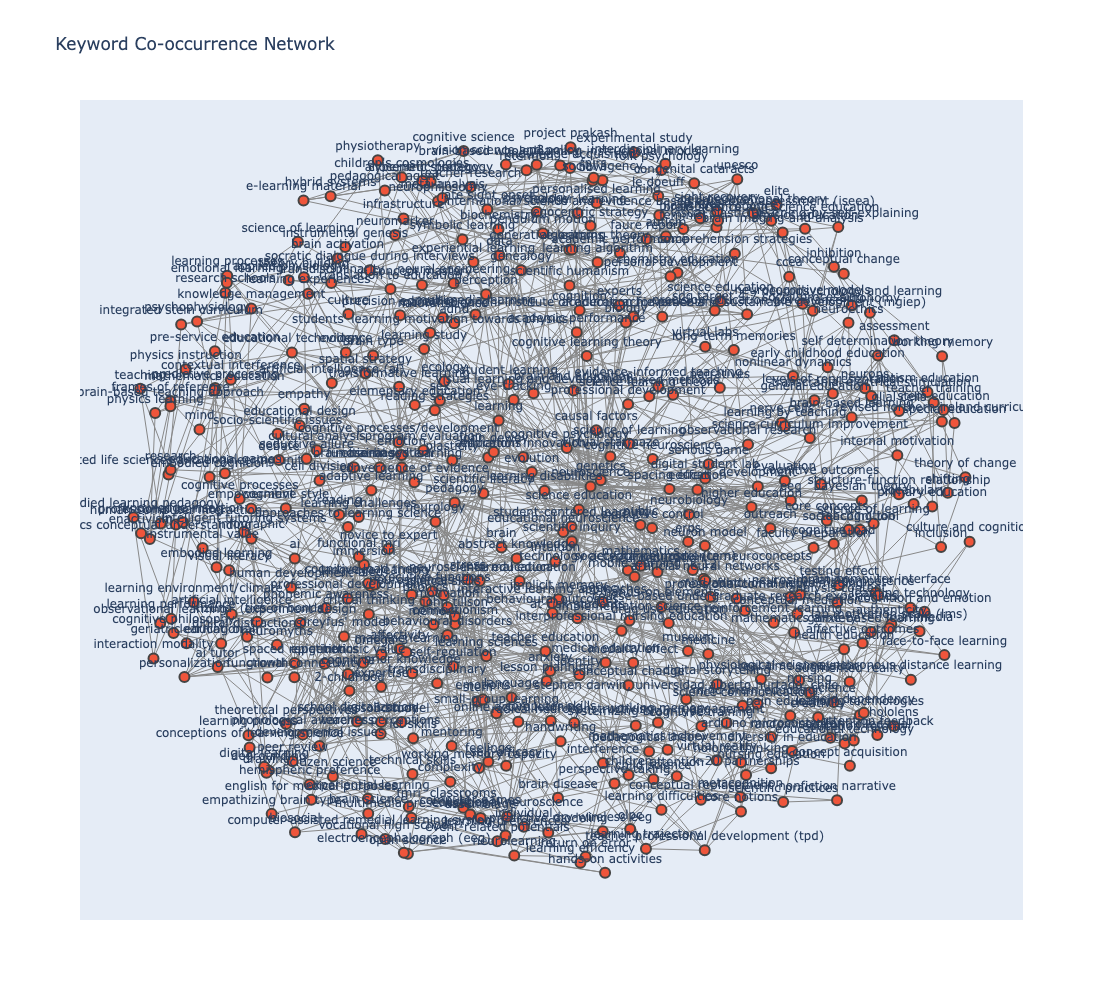

In [101]:
import networkx as nx
import plotly.graph_objects as go
from itertools import combinations

# --- Keyword Network Graph ---
# 1. Build co-occurrence counts from keywords column
edge_counts = {}
nodes = set()
for kw_list in df['keywords'].dropna():
    kws = [k.strip().lower() for k in kw_list.split(';') if k.strip()]
    for a, b in combinations(kws, 2):
        edge_counts[(a, b)] = edge_counts.get((a, b), 0) + 1
        nodes.update([a, b])

# 2. Create NetworkX graph
g = nx.Graph()
for node in nodes:
    g.add_node(node)
for (a, b), w in edge_counts.items():
    g.add_edge(a, b, weight=w)

# 3. Generate positions
pos = nx.spring_layout(g, k=0.5, seed=42)

# 4. Create Plotly traces
edge_x = []
edge_y = []
edge_width = []
for u, v, data in g.edges(data=True):
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]
    edge_width.append(data['weight'])

edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=1, color='#888'),
    hoverinfo='none',
    mode='lines'
)

node_x = []
node_y = []
node_text = []
for node in g.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(f"{node}")

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    text=node_text,
    textposition='top center',
    hoverinfo='text',
    marker=dict(
        size=10,
        line_width=2
    )
)

# 5. Plot network
fig_net = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title='Keyword Co-occurrence Network',
                        showlegend=False,
                        width=1000,
                        height=1000,
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                    ))
fig_net.show()

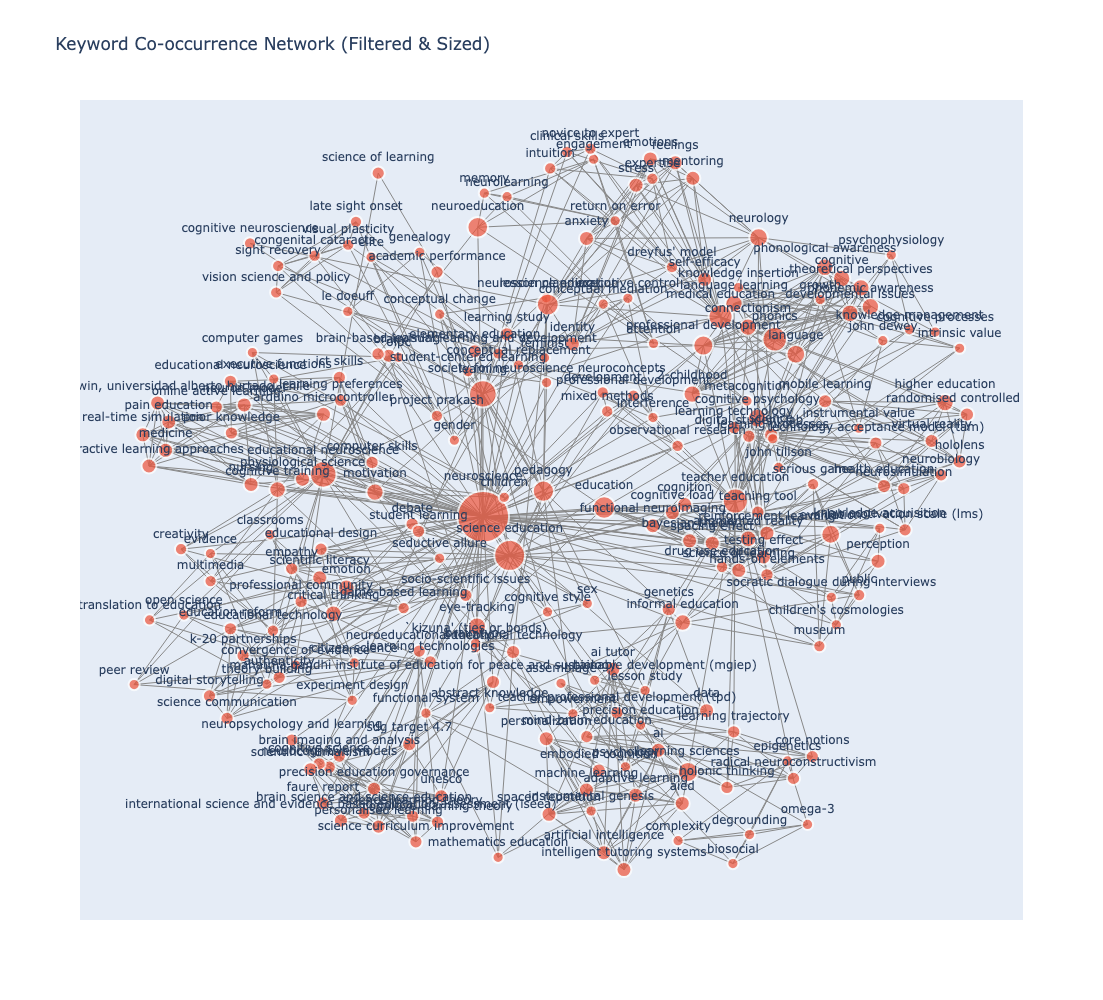

In [103]:
# 1. Build co-occurrence counts and node frequencies
edge_counts = {}
node_freq = {}
for kw_list in df['keywords'].dropna():
    kws = [k.strip().lower() for k in kw_list.split(';') if k.strip()]
    for a, b in combinations(sorted(kws), 2):
        edge_counts[(a, b)] = edge_counts.get((a, b), 0) + 1
        node_freq[a] = node_freq.get(a, 0) + 1
        node_freq[b] = node_freq.get(b, 0) + 1

# 2. Determine thresholds
edge_threshold = np.percentile(list(edge_counts.values()), 95)  # top 5% edges
node_threshold = np.percentile(list(node_freq.values()), 50)   # top 50% nodes (median)

# 3. Create filtered NetworkX graph
g = nx.Graph()
for (a, b), w in edge_counts.items():
    if w >= edge_threshold and node_freq[a] >= node_threshold and node_freq[b] >= node_threshold:
        g.add_edge(a, b, weight=w)

# 4. Generate positions
pos = nx.spring_layout(g, k=0.5, seed=42)

# 5. Build Plotly traces
# Edge trace
edge_x, edge_y = [], []
for u, v in g.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1, color='#888'),
    hoverinfo='none', mode='lines'
)

# Node trace with size by frequency and custom hover text
node_x, node_y, node_text, node_size = [], [], [], []
for node in g.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    freq = node_freq[node]
    # Define hover text per node
    hover_str = f"Keyword: {node}<br>Frequency: {freq}<br>Degree: {g.degree(node)}"
    node_text.append(hover_str)
    # Scale marker size based on frequency
    node_size.append(np.sqrt(freq) * 5)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=[node for node in g.nodes()],  # labels on the plot
    textposition='top center',
    hoverinfo='text',  # show hovertext
    hovertext=node_text,  # customize hover text
    marker=dict(size=node_size, line_width=2)
)

# 6. Plot network
fig_net = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        title='Keyword Co-occurrence Network (Filtered & Sized)',
        showlegend=False,
        width=1000, height=1000,
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
)
fig_net.show()